<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/AE%20ECG%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Good link for theory:
https://machinelearningmastery.com/lstm-autoencoders/

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
url_link = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/ecg_1d_timeseries_prediction.csv'


# --- Configuration ---
input_window = 100  # Number of input steps
output_window = 100  # Number of prediction steps
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load and Prepare Data ---
# Load the ECG data from the uploaded CSV file
# The data seems to be semicolon-separated and has headers in the first row
df = pd.read_csv(url_link, sep=';')

# Check the columns to identify the correct one for the ECG signal
print("Columns in the DataFrame:", df.columns.tolist())

Using device: cpu
Columns in the DataFrame: ['time', 'ecg_value']


In [ ]:
# Assuming the ECG signal is in the second column named 'ecg_value'
ecg_signal_column = 'ecg_value'
if ecg_signal_column not in df.columns:
    print(f"Warning: Column '{ecg_signal_column}' not found. Using the first available column after 'time'.")
    ecg_signal_column = df.columns[1] # Second column

series = df[ecg_signal_column].values # Extract the ECG signal as a numpy array
print(f"Original ECG series shape: {series.shape}")

# Optional: Remove any potential NaN values introduced during loading
series = series[~pd.isna(series)]
print(f"ECG series shape after removing NaN: {series.shape}")

# --- Normalize the data ---
# Using MinMaxScaler to bring values into a standard range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
# Reshape for scaler: (n_samples, n_features)
series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()


Original ECG series shape: (17935,)
ECG series shape after removing NaN: (17935,)


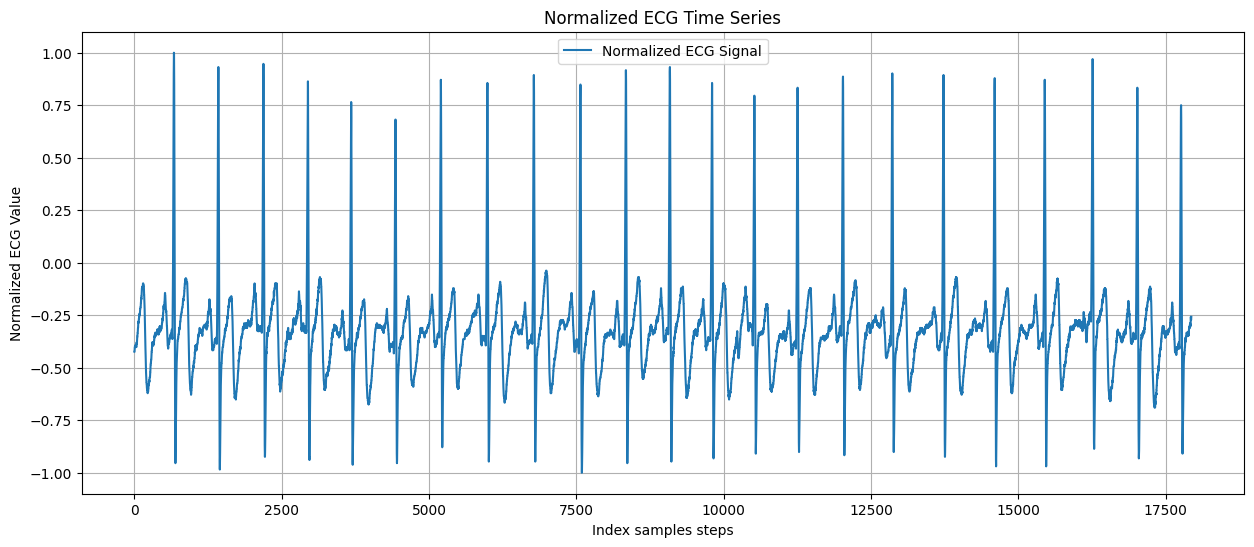

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(series_scaled, label='Normalized ECG Signal')
plt.title('Normalized ECG Time Series')
plt.xlabel('Index samples steps')
plt.ylabel('Normalized ECG Value')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Autoencoder example

In [ ]:

# --- Dataset Preparation Functions ---

def create_inout_sequences(input_data, tw, ow):
    """Create input-output pairs for the model.
    Input: sequence of length 'tw'.
    Target: sequence of length 'ow' starting right after the input sequence.
    """
    inout_seq = []
    L = len(input_data)
    # Ensure we don't go out of bounds when creating sequences
    # We need at least tw + ow points to create one sample
    for i in range(L - tw - ow + 1):
        train_seq = input_data[i : i + tw]
        # The target starts exactly after the input sequence ends
        train_label = input_data[i + tw : i + tw + ow]
        # Store as a tuple of (input_tensor, target_tensor)
        # Shape of tensors: (seq_len,) -> (seq_len, 1) when fed to model
        inout_seq.append((torch.FloatTensor(train_seq), torch.FloatTensor(train_label)))
    # Return list of tuples. Batching happens later.
    return inout_seq

def get_data(data, split_ratio):
    """Split data into train and test sequences."""
    split_index = int(split_ratio * len(data))
    train_data = data[:split_index]
    test_data = data[split_index:]

    # Create sequences for training and testing
    train_seq = create_inout_sequences(train_data, input_window, output_window)
    test_seq = create_inout_sequences(test_data, input_window, output_window)

    return train_seq, test_seq



# --- Training/Validation Helpers ---
def get_batch(source, i, batch_size):
    # Get a slice of the dataset list of tuples
    batch_end_idx = min(i + batch_size, len(source))
    batch_data = source[i : batch_end_idx]

    # Separate inputs and targets, stack them into batched tensors
    inputs = torch.stack([item[0] for item in batch_data]) # Shape: (batch_size_actual, input_window)
    targets = torch.stack([item[1] for item in batch_data]) # Shape: (batch_size_actual, output_window)

    # Add feature dimension (1) -> (batch_size, seq_len, 1)
    return inputs.unsqueeze(-1).to(device), targets.unsqueeze(-1).to(device)

def train_epoch(model, train_data, optimizer, criterion):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx in range(0, len(train_data), batch_size):
        # Get batch data
        data, targets = get_batch(train_data, batch_idx, batch_size)

        optimizer.zero_grad()
        output = model(data) # Output shape: (batch_size_actual, output_window=1, 1)
        # Squeeze dimensions for loss calculation: (batch_size_actual * output_window,)
        loss = criterion(output.squeeze(), targets.squeeze())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Clip gradient
        optimizer.step()

        total_loss += loss.item()

        # Logging
        if batch_idx % max(1, len(train_data) // 5) == 0 and batch_idx > 0: # Log ~5 times per epoch
            avg_loss = total_loss / ((batch_idx // batch_size) + 1)
            elapsed = time.time() - start_time
            print(f'| Batch {batch_idx//batch_size:3d} | '
                  f'Time: {elapsed * 1000:.2f}ms | '
                  f'Loss: {avg_loss:.7f}')

    return total_loss / len(train_data)

def evaluate(model, data_source, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
             data, targets = get_batch(data_source, i, batch_size)
             output = model(data)
             total_loss += criterion(output.squeeze(), targets.squeeze()).item()
    return total_loss / len(data_source)

In [ ]:
class AutoencoderModel(nn.Module):
    def __init__(self, feature_dim=1, hidden_size=64, latent_dim=10):
        super(AutoencoderModel, self).__init__()
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim

        # Add a linear layer to project the 1D input to feature_dim
        self.feature_projection = nn.Linear(1, feature_dim)

        # Encoder: LSTM to compress the input sequence into a hidden state
        # input_size now expects feature_dim after projection
        self.encoder_lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_size,
            batch_first=True  # Input and output tensors are provided as (batch, seq, feature)
        )

        # Linear layer to project the LSTM's last hidden state to a latent representation
        self.latent_projection = nn.Linear(hidden_size, latent_dim)

        # Decoder: Linear layer to predict the next value from the latent representation
        # Modified to output 'output_window' values instead of 1
        self.decoder_linear = nn.Linear(latent_dim, output_window)

    def forward(self, x):
        # x shape: (batch_size, input_window, feature_dim=1)

        # Project 1D input feature to higher dimensional space
        x = self.feature_projection(x) # Shape: (batch_size, input_window, feature_dim)

        # Encoder
        # LSTM returns output, (h_n, c_n)
        # h_n shape: (num_layers * num_directions, batch, hidden_size)
        # Since we have one layer and unidirectional LSTM, h_n will be (1, batch, hidden_size)
        _, (hidden, _) = self.encoder_lstm(x)

        # We take the last hidden state of the LSTM (from the last layer/direction)
        # Squeeze the first dimension to get (batch, hidden_size)
        hidden = hidden.squeeze(0) # Shape: (batch_size, hidden_size)

        # Project to latent space
        latent_representation = self.latent_projection(hidden) # Shape: (batch_size, latent_dim)

        # Decoder
        # Predict the next value from the latent representation
        prediction = self.decoder_linear(latent_representation) # Shape: (batch_size, output_window)

        return prediction.unsqueeze(-1) # Add an extra dimension for compatibility with target (batch_size, output_window, 1)

In [20]:
# Redefine output_window for 10-point prediction as requested
output_window = 50

print("\n--- Training Autoencoder Model ---")

train_data, val_data = get_data(series_scaled, 0.8) # 80% train, 20% validation

# --- Main Execution ---
train_data, val_data = get_data(series_scaled, 0.8) # 80% train, 20% validation
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
# Print shape of first sample to confirm
first_input, first_target = train_data[0]
print(f"Shape of first input sequence: {first_input.shape}")
print(f"Shape of first target sequence: {first_target.shape}")

# Initiate the AutoencoderModel
# hidden_size and latent_dim can be tuned, starting with reasonable defaults
'''
In the AutoencoderModel, feature_dim=100 refers to the dimension into which the single input feature (the normalized ECG value) is projected. Initially, each time step of your ECG signal is a single numerical value (1D). The feature_projection layer, defined as nn.Linear(1, feature_dim), takes this 1-dimensional input and transforms it into a 100-dimensional vector. This allows the LSTM encoder to work with a richer, higher-dimensional representation of each time step, potentially helping the model to capture more complex patterns and relationships within the data than it might with just a single feature.
'''
autoencoder_model = AutoencoderModel(feature_dim=10, hidden_size=64, latent_dim=10).to(device)

autoencoder_criterion = nn.MSELoss()
autoencoder_lr = 0.01
autoencoder_epochs = 10 # Using the same number of epochs for comparison

autoencoder_optimizer = torch.optim.AdamW(autoencoder_model.parameters(), lr=autoencoder_lr)
autoencoder_scheduler = torch.optim.lr_scheduler.StepLR(autoencoder_optimizer, step_size=1, gamma=0.98)

autoencoder_train_losses = []
autoencoder_val_losses = []

print("Starting Autoencoder Training...")
for epoch in range(1, autoencoder_epochs + 1):
    epoch_start_time = time.time()
    train_loss_ae = train_epoch(autoencoder_model, train_data, autoencoder_optimizer, autoencoder_criterion)
    val_loss_ae = evaluate(autoencoder_model, val_data, autoencoder_criterion)

    autoencoder_train_losses.append(train_loss_ae)
    autoencoder_val_losses.append(val_loss_ae)

    print(f"-" * 89)
    print(f"| End of epoch {epoch:3d} | Train Loss (AE): {train_loss_ae:.7f} | Val Loss (AE): {val_loss_ae:.7f} | "
          f"Epoch Time: {(time.time() - epoch_start_time):.2f}s")
    print("-" * 89)

    autoencoder_scheduler.step()

print("Autoencoder Training Finished!")


--- Training Autoencoder Model ---
Number of training samples: 14049
Number of validation samples: 3288
Shape of first input sequence: torch.Size([100])
Shape of first target sequence: torch.Size([200])
Starting Autoencoder Training...
-----------------------------------------------------------------------------------------
| End of epoch   1 | Train Loss (AE): 0.0002624 | Val Loss (AE): 0.0002343 | Epoch Time: 11.67s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   2 | Train Loss (AE): 0.0001932 | Val Loss (AE): 0.0002260 | Epoch Time: 12.20s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   3 | Train Loss (AE): 0.0001806 | Val Loss (AE): 0.0002151 | Epoch Time: 13.59s
-------------------------

In [21]:
print(autoencoder_model)

AutoencoderModel(
  (feature_projection): Linear(in_features=1, out_features=10, bias=True)
  (encoder_lstm): LSTM(10, 64, batch_first=True)
  (latent_projection): Linear(in_features=64, out_features=10, bias=True)
  (decoder_linear): Linear(in_features=10, out_features=200, bias=True)
)


Visualize performance by plotting the training and validation losses over epochs. This will help assess the model's learning progress and identify potential overfitting or underfitting issues.



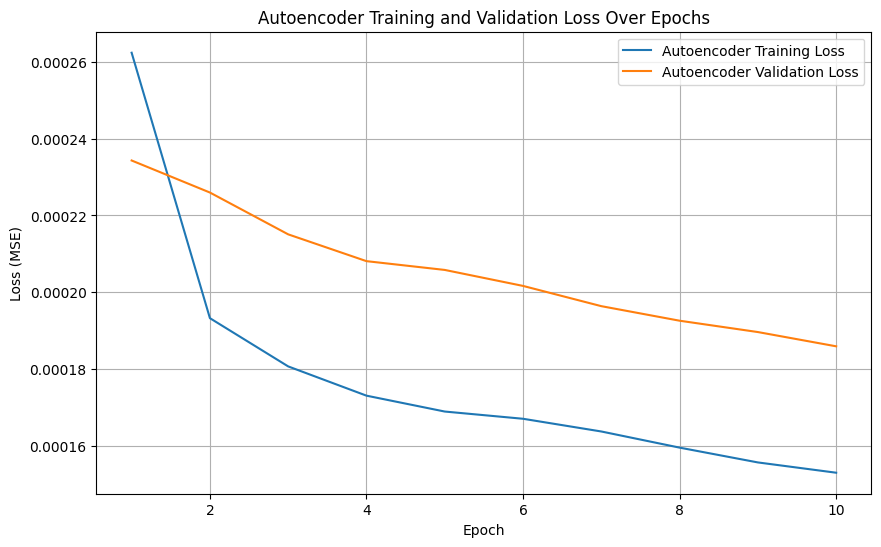

In [22]:
epochs_range_ae = range(1, autoencoder_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range_ae, autoencoder_train_losses, label='Autoencoder Training Loss')
plt.plot(epochs_range_ae, autoencoder_val_losses, label='Autoencoder Validation Loss')
plt.title('Autoencoder Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

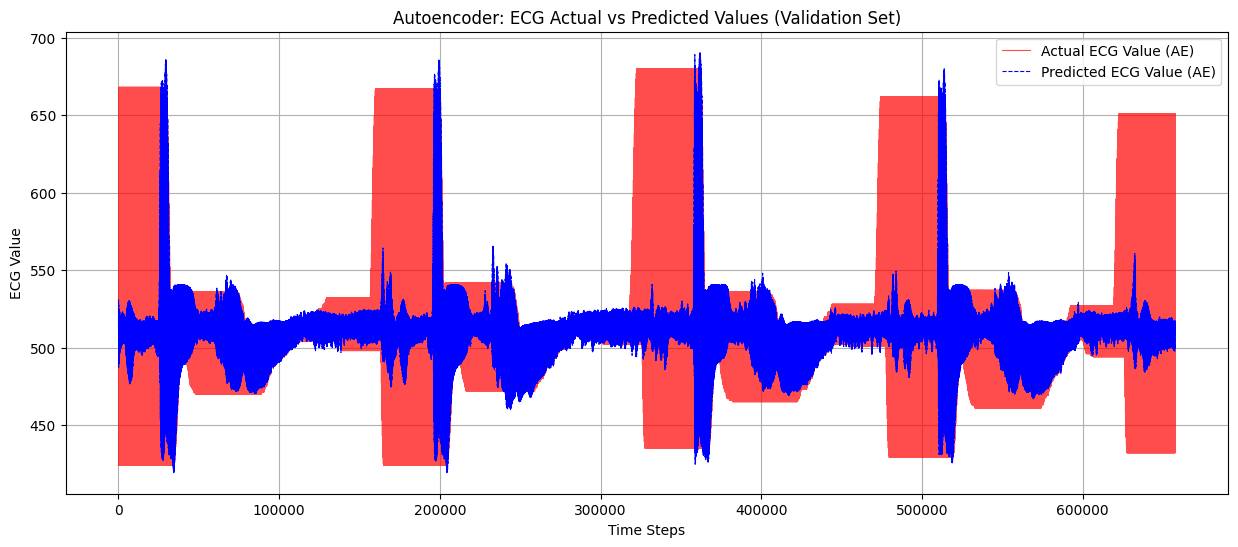

In [23]:
autoencoder_model.eval()
all_predictions_ae = []
all_targets_ae = []
with torch.no_grad():
    for i in range(0, len(val_data), batch_size):
        data, targets = get_batch(val_data, i, batch_size)
        output = autoencoder_model(data)
        all_predictions_ae.extend(output.squeeze().cpu().numpy())
        all_targets_ae.extend(targets.squeeze().cpu().numpy())

# Inverse transform predictions and targets back to original scale
preds_original_ae = scaler.inverse_transform(np.array(all_predictions_ae).reshape(-1, 1)).flatten()
targets_original_ae = scaler.inverse_transform(np.array(all_targets_ae).reshape(-1, 1)).flatten()

plt.figure(figsize=(15, 6))
plt.plot(targets_original_ae, label='Actual ECG Value (AE)', color='red', alpha=0.7, linewidth=0.8)
plt.plot(preds_original_ae, label='Predicted ECG Value (AE)', color='blue', linestyle='--', linewidth=0.8)
plt.title('Autoencoder: ECG Actual vs Predicted Values (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)
plt.show()

# Latent Space Visualisation
To extract the latent representations from the autoencoder model, apply PCA for dimensionality reduction, and visualize the latent space, execute the following code. This will help us understand how the model encodes the input ECG sequences into a compressed form.


Extracting latent representations from the autoencoder model...
Shape of extracted latent representations: (3288, 10)
Applying PCA to reduce latent representations to 2 dimensions...
Shape of 2D latent representations after PCA: (3288, 2)
Visualizing the latent space...


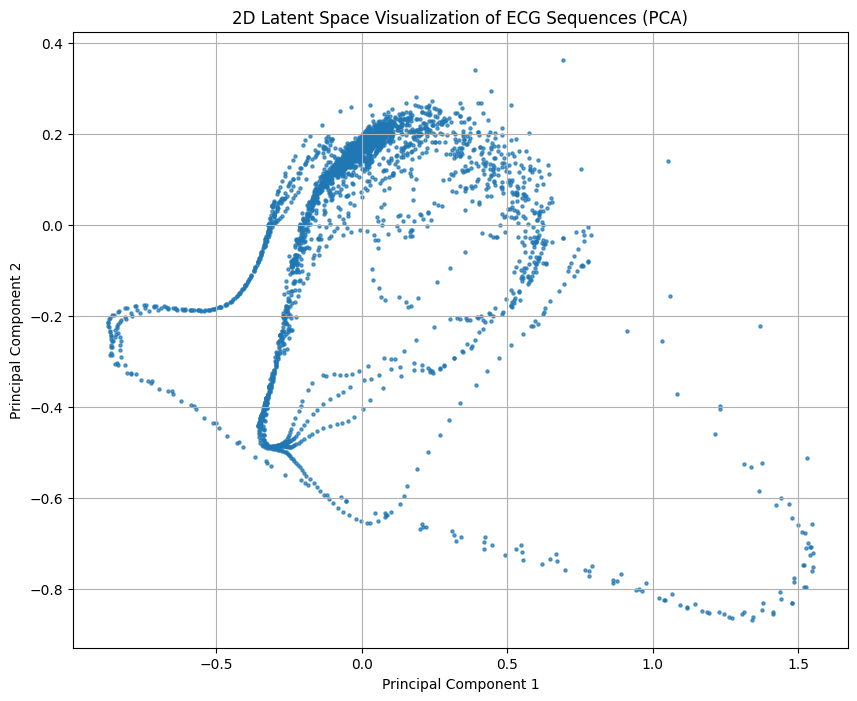

In [29]:

from sklearn.decomposition import PCA

# --- 1. Extract Latent Representations ---
print("Extracting latent representations from the autoencoder model...")

def get_latent_representations(model, data_source):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, _ = get_batch(data_source, i, batch_size)
            # Reconstruct the forward pass up to the latent_projection layer
            x = model.feature_projection(data)
            _, (hidden, _) = model.encoder_lstm(x)
            hidden = hidden.squeeze(0)
            latent = model.latent_projection(hidden)
            latent_vectors.append(latent.cpu().numpy())
    return np.vstack(latent_vectors)

# Get latent representations for the validation data
val_latent_representations = get_latent_representations(autoencoder_model, val_data)
print(f"Shape of extracted latent representations: {val_latent_representations.shape}")

# --- 2. Apply Dimensionality Reduction (PCA) ---
print("Applying PCA to reduce latent representations to 2 dimensions...")
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(val_latent_representations)
print(f"Shape of 2D latent representations after PCA: {latent_2d.shape}")

# --- 3. Visualize Latent Space ---
print("Visualizing the latent space...")
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7, s=5)
plt.title('2D Latent Space Visualization of ECG Sequences (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

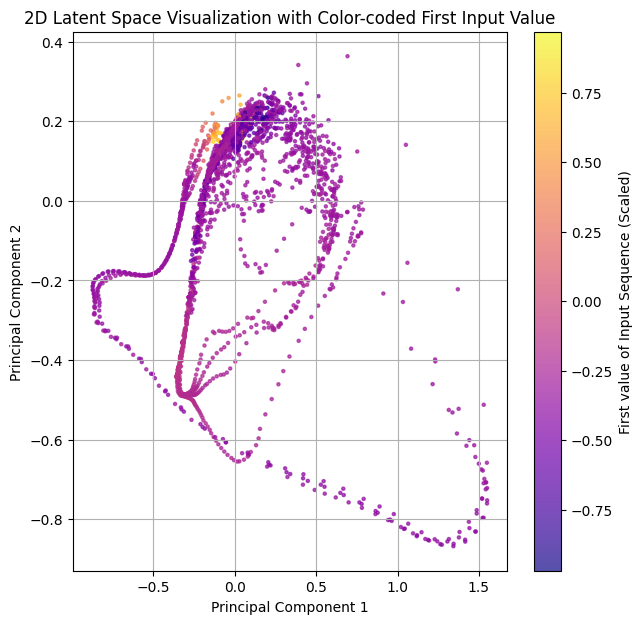

In [37]:
# We can color by the first value of the original sequence to see if there's any pattern
# based on the initial state of the input window.
first_values_in_val_data = np.array([item[0][0].item() for item in val_data])

plt.figure(figsize=(7, 7))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=first_values_in_val_data, cmap='plasma', alpha=0.7, s=5)
plt.colorbar(scatter, label='First value of Input Sequence (Scaled)')
plt.title('2D Latent Space Visualization with Color-coded First Input Value')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Extract latent representations from the autoencoder model and then applying it to the validation data. This function will specifically pass data through the feature_projection, encoder_lstm, and latent_projection layers of the model, as instructed.



In [31]:
def get_latent_representations(model, data_source):
    model.eval() # Set the model to evaluation mode
    latent_representations = []
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
            data, _ = get_batch(data_source, i, batch_size)

            # Pass through feature_projection
            projected_features = model.feature_projection(data)

            # Pass through encoder_lstm
            # _, (hidden, _) = model.encoder_lstm(projected_features)
            # The `encoder_lstm` expects input of shape (batch_size, seq_len, input_size)
            # and returns (output, (h_n, c_n))
            # h_n shape: (num_layers * num_directions, batch, hidden_size)
            _, (hidden, _) = model.encoder_lstm(projected_features)

            # Squeeze the hidden state to get (batch, hidden_size)
            hidden = hidden.squeeze(0)

            # Pass through latent_projection
            latent = model.latent_projection(hidden)
            latent_representations.extend(latent.cpu().numpy())

    return np.array(latent_representations)

# Get latent representations for the validation set
val_latent_representations = get_latent_representations(autoencoder_model, val_data)

# Print the shape of the latent representations
print(f"Shape of validation latent representations: {val_latent_representations.shape}")

Shape of validation latent representations: (3288, 10)


Apply Principal Component Analysis (PCA) to reduce their dimensionality to two components for visualization. After reduction, two scatter plots will be generated to visualize the latent space: one basic plot and another with points colored by the first value of the input sequence to reveal potential patterns.



Applying PCA to reduce latent representations to 2 dimensions...
Shape of 2D latent representations after PCA: (3288, 2)

Visualizing specific input sequences and their projection into the latent space...


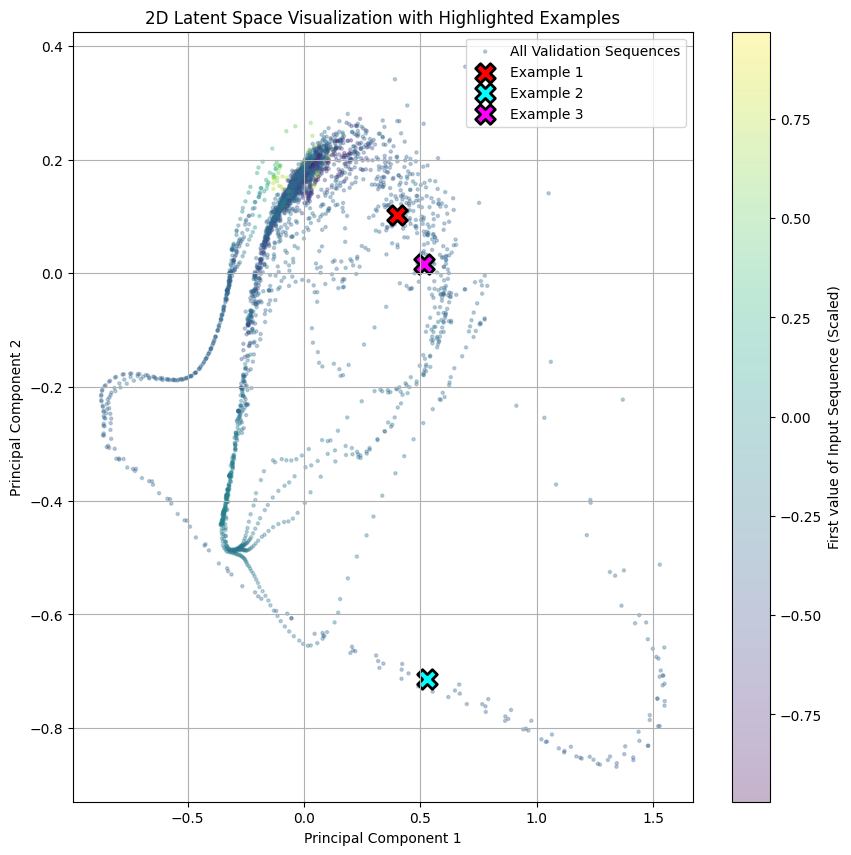

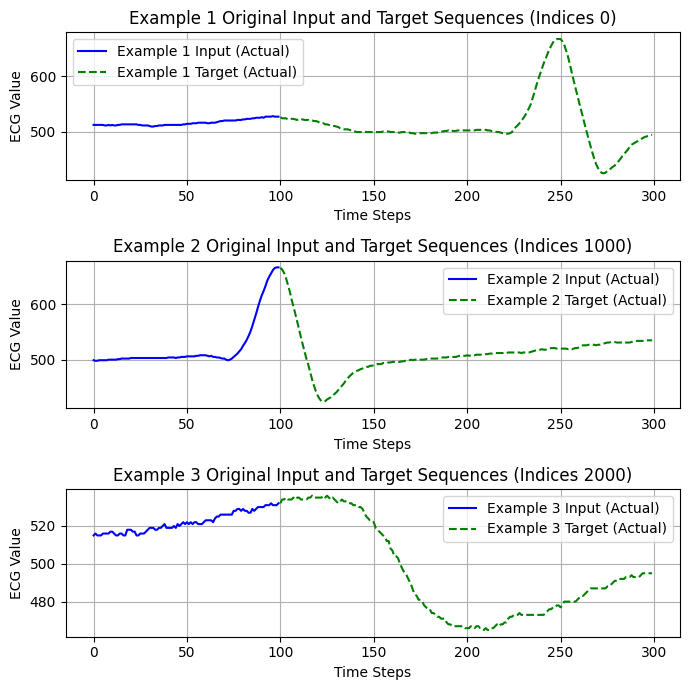

In [35]:
from sklearn.decomposition import PCA

# --- 2. Apply Dimensionality Reduction (PCA) ---
print("Applying PCA to reduce latent representations to 2 dimensions...")
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(val_latent_representations)
print(f"Shape of 2D latent representations after PCA: {latent_2d.shape}")


# --- Visualize specific input sequences and their latent representations ---
print("\nVisualizing specific input sequences and their projection into the latent space...")

example_indices = [0, 1000, 2000] # Choose some example indices from the validation set
colors = ['red', 'cyan', 'magenta'] # Colors for highlighting
labels = ['Example 1', 'Example 2', 'Example 3']

plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=first_values_in_val_data, cmap='viridis', alpha=0.3, s=5, label='All Validation Sequences')
plt.colorbar(scatter, label='First value of Input Sequence (Scaled)')

# Plot the highlighted examples
for i, idx in enumerate(example_indices):
    # Get the latent representation for this specific example
    # Need to wrap it in a list to use get_latent_representations
    single_example_latent = get_latent_representations(autoencoder_model, [val_data[idx]])
    single_example_latent_2d = pca.transform(single_example_latent)

    plt.scatter(single_example_latent_2d[:, 0], single_example_latent_2d[:, 1],
                color=colors[i], marker='X', s=200, edgecolor='black', linewidth=2, label=labels[i])

plt.title('2D Latent Space Visualization with Highlighted Examples')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Now plot the actual input sequences for these examples
plt.figure(figsize=(7, 7))
for i, idx in enumerate(example_indices):
    example_input_seq_scaled = val_data[idx][0].cpu().numpy() # Input window
    example_target_seq_scaled = val_data[idx][1].cpu().numpy() # Target window

    # Inverse transform to original scale for plotting
    input_orig = scaler.inverse_transform(example_input_seq_scaled.reshape(-1, 1)).flatten()
    target_orig = scaler.inverse_transform(example_target_seq_scaled.reshape(-1, 1)).flatten()

    plt.subplot(len(example_indices), 1, i + 1)
    plt.plot(input_orig, label=f'{labels[i]} Input (Actual)', color='blue')
    plt.plot(np.arange(len(input_orig), len(input_orig) + len(target_orig)), target_orig,
             label=f'{labels[i]} Target (Actual)', color='green', linestyle='--')
    plt.title(f'{labels[i]} Original Input and Target Sequences (Indices {idx})')
    plt.xlabel('Time Steps')
    plt.ylabel('ECG Value')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Transformer example

In [ ]:

# --- Dataset Preparation Functions ---

def create_inout_sequences(input_data, tw, ow):
    """Create input-output pairs for the model.
    Input: sequence of length 'tw'.
    Target: sequence of length 'ow' starting right after the input sequence.
    """
    inout_seq = []
    L = len(input_data)
    # Ensure we don't go out of bounds when creating sequences
    # We need at least tw + ow points to create one sample
    for i in range(L - tw - ow + 1):
        train_seq = input_data[i : i + tw]
        # The target starts exactly after the input sequence ends
        train_label = input_data[i + tw : i + tw + ow]
        # Store as a tuple of (input_tensor, target_tensor)
        # Shape of tensors: (seq_len,) -> (seq_len, 1) when fed to model
        inout_seq.append((torch.FloatTensor(train_seq), torch.FloatTensor(train_label)))
    # Return list of tuples. Batching happens later.
    return inout_seq

def get_data(data, split_ratio):
    """Split data into train and test sequences."""
    split_index = int(split_ratio * len(data))
    train_data = data[:split_index]
    test_data = data[split_index:]

    # Create sequences for training and testing
    train_seq = create_inout_sequences(train_data, input_window, output_window)
    test_seq = create_inout_sequences(test_data, input_window, output_window)

    return train_seq, test_seq

# --- Model Definition (Adjusted for 1D Input and Correct Output) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape expected: (seq_len, batch_size, d_model)
        # pe is broadcastable to (seq_len, 1, d_model)
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module):
    def __init__(self, feature_size=200, num_layers=1, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_type = "Transformer"
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)

        # The encoder layer now expects the feature dimension after reshaping
        # Input to transformer will be (seq_len, batch_size, feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_size, nhead=10, dropout=dropout, batch_first=False # Important: batch_first=False for positional encoding compatibility
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        # Adjust decoder to map the final hidden state to a single output
        self.decoder = nn.Linear(feature_size, 1)
        # A linear layer to project the 1D input value to the higher dimensional feature space
        self.feature_projection = nn.Linear(1, feature_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        # Initialize feature_projection weights too
        self.feature_projection.bias.data.zero_()
        self.feature_projection.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src shape: (batch_size, seq_len, 1)
        batch_size, seq_len, _ = src.shape

        if self.src_mask is None or self.src_mask.size(0) != seq_len:
            device = src.device
            mask = self._generate_square_subsequent_mask(seq_len).to(device)
            self.src_mask = mask

        # Project 1D feature to higher dimensional space
        src = self.feature_projection(src) # Shape: (batch_size, seq_len, feature_size)

        # Transpose for positional encoding: (seq_len, batch_size, feature_size)
        src = src.transpose(0, 1)
        src = self.pos_encoder(src) # Apply positional encoding
        # Transpose back for transformer encoder: (seq_len, batch_size, feature_size)
        src = src.transpose(0, 1)

        # Transformer expects (seq_len, batch_size, feature_size) with batch_first=False
        # But our input is (batch_size, seq_len, feature_size) after projection
        # So we transpose again before feeding to encoder and transpose output back
        src = src.transpose(0, 1) # -> (seq_len, batch_size, feature_size)
        output = self.transformer_encoder(src, self.src_mask)
        output = output.transpose(0, 1) # -> (batch_size, seq_len, feature_size)

        # --- CRITICAL FIX ---
        # Only take the output corresponding to the last input timestep for prediction
        # This matches the target shape [batch_size, output_window=1, 1]
        output = output[:, -output_window:, :] # Shape: (batch_size, output_window, feature_size)
        # Decode to get the final prediction
        output = self.decoder(output) # Shape: (batch_size, output_window, 1)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

# --- Training/Validation Helpers ---
def get_batch(source, i, batch_size):
    # Get a slice of the dataset list of tuples
    batch_end_idx = min(i + batch_size, len(source))
    batch_data = source[i : batch_end_idx]

    # Separate inputs and targets, stack them into batched tensors
    inputs = torch.stack([item[0] for item in batch_data]) # Shape: (batch_size_actual, input_window)
    targets = torch.stack([item[1] for item in batch_data]) # Shape: (batch_size_actual, output_window)

    # Add feature dimension (1) -> (batch_size, seq_len, 1)
    return inputs.unsqueeze(-1).to(device), targets.unsqueeze(-1).to(device)

def train_epoch(model, train_data, optimizer, criterion):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch_idx in range(0, len(train_data), batch_size):
        # Get batch data
        data, targets = get_batch(train_data, batch_idx, batch_size)

        optimizer.zero_grad()
        output = model(data) # Output shape: (batch_size_actual, output_window=1, 1)
        # Squeeze dimensions for loss calculation: (batch_size_actual * output_window,)
        loss = criterion(output.squeeze(), targets.squeeze())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Clip gradient
        optimizer.step()

        total_loss += loss.item()

        # Logging
        if batch_idx % max(1, len(train_data) // 5) == 0 and batch_idx > 0: # Log ~5 times per epoch
            avg_loss = total_loss / ((batch_idx // batch_size) + 1)
            elapsed = time.time() - start_time
            print(f'| Batch {batch_idx//batch_size:3d} | '
                  f'Time: {elapsed * 1000:.2f}ms | '
                  f'Loss: {avg_loss:.7f}')

    return total_loss / len(train_data)

def evaluate(model, data_source, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i in range(0, len(data_source), batch_size):
             data, targets = get_batch(data_source, i, batch_size)
             output = model(data)
             total_loss += criterion(output.squeeze(), targets.squeeze()).item()
    return total_loss / len(data_source)

# --- Main Execution ---
train_data, val_data = get_data(series_scaled, 0.8) # 80% train, 20% validation
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
# Print shape of first sample to confirm
first_input, first_target = train_data[0]
print(f"Shape of first input sequence: {first_input.shape}")
print(f"Shape of first target sequence: {first_target.shape}")


model = TransformerModel(feature_size=200).to(device) # Instantiate model
criterion = nn.MSELoss()
lr = 0.0001
epochs = 10 # Reduced epochs for initial run

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.98)

train_losses = []
val_losses = []

print("Starting Training...")
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_loss = train_epoch(model, train_data, optimizer, criterion)
    val_loss = evaluate(model, val_data, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"-" * 89)
    print(f"| End of epoch {epoch:3d} | Train Loss: {train_loss:.7f} | Val Loss: {val_loss:.7f} | "
          f"Epoch Time: {(time.time() - epoch_start_time):.2f}s")
    print("-" * 89)

    scheduler.step()

print("Training Finished!")

Number of training samples: 14338
Number of validation samples: 3577
Shape of first input sequence: torch.Size([10])
Shape of first target sequence: torch.Size([1])
Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


-----------------------------------------------------------------------------------------
| End of epoch   1 | Train Loss: 0.0002334 | Val Loss: 0.0002065 | Epoch Time: 28.19s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   2 | Train Loss: 0.0000651 | Val Loss: 0.0001737 | Epoch Time: 26.31s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   3 | Train Loss: 0.0000585 | Val Loss: 0.0000160 | Epoch Time: 26.27s
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   4 | Train Loss: 0.0000364 | Val Loss: 0.0000069 | Epoch Time: 26.30s
--------------------------

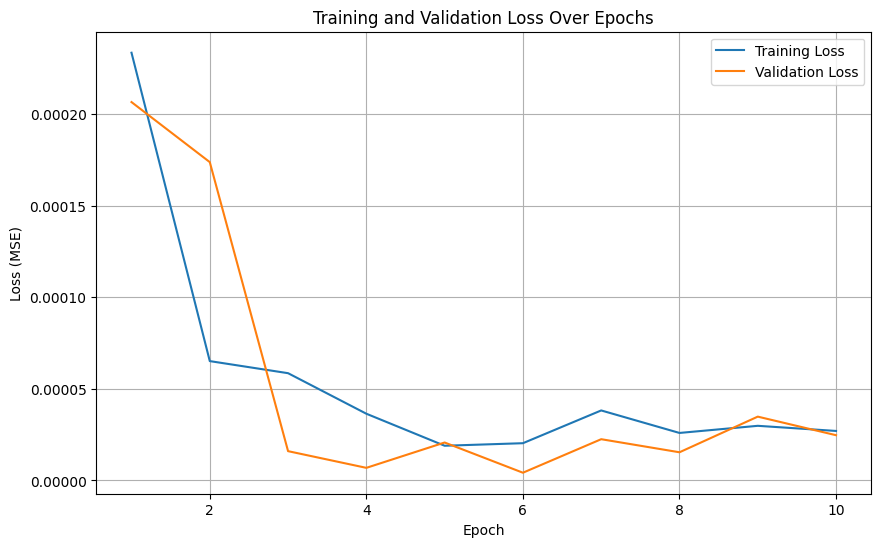

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

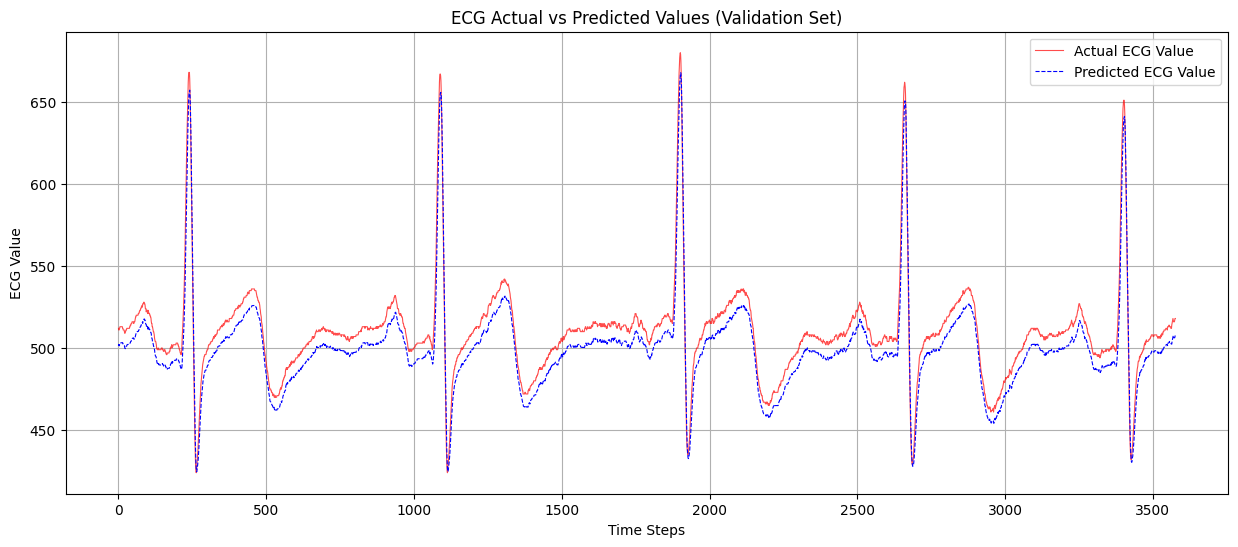


--- Single Sequence Prediction Example (First in Validation) ---
Input Sequence (last 5 values, scaled): ...[-0.28787879 -0.28787879 -0.28787879 -0.29545455 -0.29545455]
Actual Next Value (scaled): -0.3030, Original: 512.0000
Predicted Next Value (scaled): -0.3682, Original: 503.3923
Difference (Original Scale): 8.6077

--- Loading ECG data for plot... ---
    time  ecg_value
0  0.000        496
1  0.001        496
2  0.002        497
3  0.003        498
4  0.004        498
Total data points: 17935
Calculated time step (dt): 0.001000s (Implies Fs = 1000.00 Hz)
Assumed Sampling Rate: 1000 Hz
Test Points (last 0.5s): 500
Training points: 17435 (17.43s)
Testing points: 500 (0.50s)


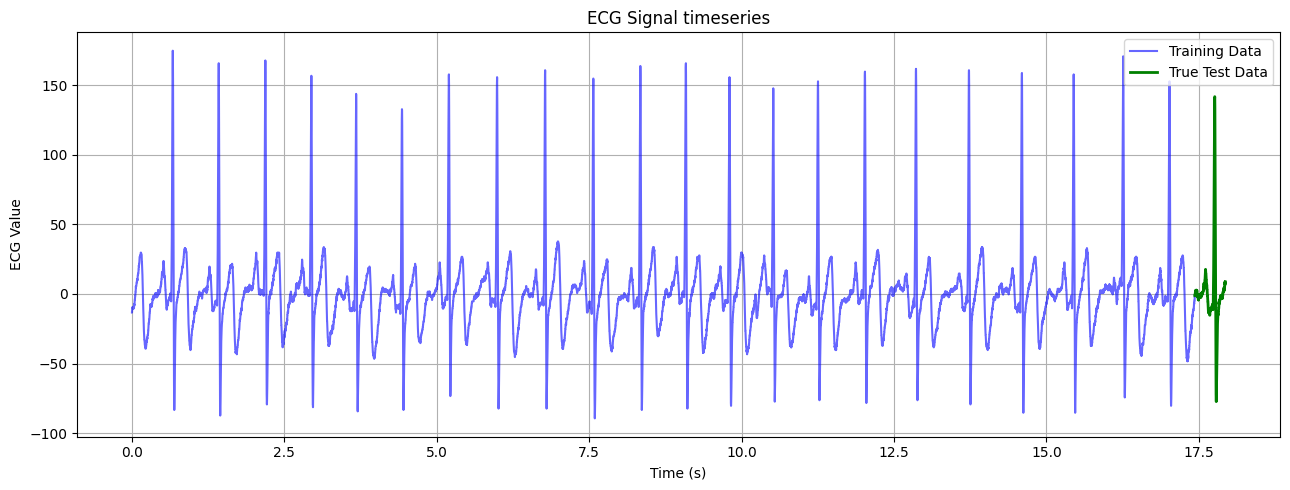

In [ ]:
# --- Plotting Results ---
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for i in range(0, len(val_data), batch_size):
         data, targets = get_batch(val_data, i, batch_size)
         output = model(data)
         # Collect predictions and targets for the whole batch
         all_predictions.extend(output.squeeze().cpu().numpy())
         all_targets.extend(targets.squeeze().cpu().numpy())


# Inverse transform predictions and targets back to original scale
preds_original = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
targets_original = scaler.inverse_transform(np.array(all_targets).reshape(-1, 1)).flatten()

plt.figure(figsize=(15, 6))
plt.plot(targets_original, label='Actual ECG Value', color='red', alpha=0.7, linewidth=0.8)
plt.plot(preds_original, label='Predicted ECG Value', color='blue', linestyle='--', linewidth=0.8)
plt.title('ECG Actual vs Predicted Values (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('ECG Value')
plt.legend()
plt.grid(True)
plt.show()

# Example of predicting a single sequence
example_idx = 0 # Start of validation set
example_seq_raw = series_scaled[len(train_data) + example_idx : len(train_data) + example_idx + input_window]
example_input = torch.tensor(example_seq_raw).float().unsqueeze(0).unsqueeze(-1).to(device) # Shape: (1, input_window, 1)

model.eval()
with torch.no_grad():
    pred_single_full = model(example_input) # This predicts the whole output window
    # For a single-step prediction (output_window=1), we take the first output
    pred_single = pred_single_full[:, 0, :] # Shape: (1, 1)

actual_next_value_scaled = series_scaled[len(train_data) + example_idx + input_window]
predicted_next_value_scaled = pred_single.item() # Get the scalar value

# Inverse transform the single prediction and actual value
actual_next_orig = scaler.inverse_transform([[actual_next_value_scaled]])[0][0]
predicted_next_orig = scaler.inverse_transform([[predicted_next_value_scaled]])[0][0]

print("\n--- Single Sequence Prediction Example (First in Validation) ---")
print(f"Input Sequence (last 5 values, scaled): ...{example_seq_raw[-5:]}")
print(f"Actual Next Value (scaled): {actual_next_value_scaled:.4f}, Original: {actual_next_orig:.4f}")
print(f"Predicted Next Value (scaled): {predicted_next_value_scaled:.4f}, Original: {predicted_next_orig:.4f}")
print(f"Difference (Original Scale): {abs(actual_next_orig - predicted_next_orig):.4f}")

# --- Plot requested data ---
# --- 1. Load and Prepare ECG Data ---
print("\n--- Loading ECG data for plot... ---")
df_plot = pd.read_csv(url_link, delimiter=';')
print(df_plot.head())
print(f"Total data points: {len(df_plot)}")
dt_calculated = df_plot['time'].diff().mean()
print(f"Calculated time step (dt): {dt_calculated:.6f}s (Implies Fs = {1/dt_calculated:.2f} Hz)")
fs = 1/dt_calculated

time_full = df_plot['time'].values
ecg_full = df_plot['ecg_value'].values
ecg_full = ecg_full - ecg_full.mean() # Detrend

# Define split: last 0.5 seconds for testing
test_duration_sec = 0.5
sampling_rate = int(np.round(1.0 / dt_calculated))
test_points = int(test_duration_sec * sampling_rate)

print(f"Assumed Sampling Rate: {sampling_rate} Hz")
print(f"Test Points (last {test_duration_sec}s): {test_points}")

time_train = time_full[:-test_points]
ecg_train = ecg_full[:-test_points]
time_test = time_full[-test_points:]
ecg_test_true = ecg_full[-test_points:]

print(f"Training points: {len(ecg_train)} ({time_train[-1] - time_train[0]:.2f}s)")
print(f"Testing points: {len(ecg_test_true)} ({time_test[-1] - time_test[0]:.2f}s)")

# Plot 1: Full time series with predictions highlighted
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

ax.plot(time_train, ecg_train, label='Training Data', color='blue', alpha=0.6)
ax.plot(time_test, ecg_test_true, label='True Test Data', color='green', linewidth=2)
ax.set_title('ECG Signal timeseries')
ax.set_xlabel('Time (s)')
ax.set_ylabel('ECG Value')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()